Anti-Surveillance: This patch could confuse object-detection systems by tricking them into perceiving something different depending on angle, making it useful in privacy-oriented applications.

Reduced Interference: When you train the entire patch for each rotation, the perturbations may overlap or cancel each other out across rotations, which could confuse the model. By focusing on the triangular region specific to each rotation, you minimize interference, allowing each rotation to distinctly target a specific class.
Focused Perturbations: Perturbations in adversarial patches work by altering small parts of the image in a way that exploits the model’s learned patterns. Limiting the perturbations to a smaller, more focused area could increase the effectiveness of each perturbation.

## Import Necessary and Packages

In [1]:
# Import Necessary and Packages
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
import torchvision.models as models
from torchvision.datasets import ImageFolder
import torch.utils.data as data
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tqdm import tqdm

# Path to the folder where the datasets are to be downloaded
DATASET_PATH = "data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models"

import pytorch_lightning as pl

# Setting the seed
pl.seed_everything(1)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")

c:\Users\saksh\OneDrive\Documents\VSCode\XAI-Assignment1\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 1


## Download the TinyImageNet Dataset

In [2]:
# Download the TinyImageNet Dataset
import urllib.request
from urllib.error import HTTPError
import zipfile

# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"

# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip")]

# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)

    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")

        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

## Load the pre-trained ResNet model with IMAGENET1K_V1 weights

In [3]:
# Load the pre-trained ResNet model with IMAGENET1K_V1 weights
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# Sets the model to evaluation mode (no training).
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False  # Freezes the model's parameters so they won't be updated during training.

## Retrieve a subset of the original ImageNet Dataset

In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."

dataset = ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

## Create and Place adversarial patch

In [24]:
# Create and Place adversarial patch
TENSOR_MEANS, TENSOR_STD = torch.FloatTensor(NORM_MEAN)[:,None,None], torch.FloatTensor(NORM_STD)[:,None,None]
def patch_forward(patch):
    # Map patch values from [-infty,infty] to ImageNet min and max
    patch = (torch.tanh(patch) + 1 - 2 * TENSOR_MEANS) / (2 * TENSOR_STD)
    return patch

def create_lower_triangular_mask(size):
    """
    Creates a lower triangular mask of the given size.
    """
    return torch.tril(torch.ones(size, size))

def apply_mask_to_patch(patch, mask):
    """
    Apply the lower triangular mask to the patch, keeping only the masked region.
    """
    return patch * mask


# Modify patch placement to only apply triangular regions
def place_patch(img, patch, mask):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0, img.shape[2] - patch.shape[1] - 1)
        w_offset = np.random.randint(0, img.shape[3] - patch.shape[2] - 1)
        patch_masked = patch_forward(patch) * mask  # Apply triangular mask
        img[i, :, h_offset:h_offset + patch.shape[1], w_offset:w_offset + patch.shape[2]] = patch_masked
    return img

from torchvision.transforms.functional import rotate
from torchvision.transforms import InterpolationMode
# Patch rotation function
def rotate_patch(patch, angle):
    return rotate(patch, angle=angle, interpolation=InterpolationMode.NEAREST)

# Patch scaling function
def scale_patch(patch, scale_factor):
    """Optionally scale the patch before applying."""
    return F.interpolate(patch.unsqueeze(0), scale_factor=scale_factor, mode="bilinear", align_corners=False).squeeze(0)

# Create a single adversarial patch
def create_single_patch(patch_size=64):
    """Create a single adversarial patch."""
    return nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True)

# Perceptual loss (Optional)
def perceptual_loss(model, img_with_patch, original_img):
    """Optional perceptual loss to improve adversarial effectiveness."""
    return torch.mean((model(img_with_patch) - model(original_img)) ** 2)

## Evaluate the effect of the adversarial patch

In [25]:
# Evaluation function for patch under different rotations (entire patch)
def eval_patch_per_rotation(model, patch, val_loader, target_class_mapping):
    model.eval()
    results = {}
    
    with torch.no_grad():
        for angle in [0, 90, 180, 270]:
            tp, tp_5, counter = 0., 0., 0.
            rotated_patch = rotate_patch(patch, angle)  # Rotate the patch for the given angle

            for img, img_labels in tqdm(val_loader, desc=f"Validating {angle}°", leave=False):
                patch_img = place_patch(img, rotated_patch, torch.ones_like(rotated_patch))  # Apply entire patch
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                
                target_class = target_class_mapping[angle]
                
                # Only count if the true label is not the target class
                mask = img_labels != target_class
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, mask).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), mask).sum()
                counter += mask.sum()

            acc = tp / counter
            top5 = tp_5 / counter
            results[angle] = {"acc": acc.item(), "top5": top5.item()}
    
    return results


## Train the patch

In [26]:
def patch_attack(model, patch_size=64, num_epochs=5, target_class_mapping=None, grad_accum_steps=4):
    if target_class_mapping is None:
        raise ValueError("target_class_mapping must be provided")

    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

    patch = create_single_patch(patch_size)
    optimizer = torch.optim.SGD([patch], lr=1e-1, momentum=0.8)
    loss_module = nn.CrossEntropyLoss()

    # Create the lower triangular mask once
    lower_triangular_mask = create_lower_triangular_mask(patch_size)

    for epoch in range(num_epochs):
        t = tqdm(train_loader, leave=False)
        total_loss = 0.0
        
        for step, (img, _) in enumerate(t):
            # Rotate the patch at 0, 90, 180, 270 degrees
            rotated_patches = [rotate_patch(patch, angle) for angle in [0, 90, 180, 270]]

            batch_loss = 0.0
            for angle, rotated_patch in zip([0, 90, 180, 270], rotated_patches):
                # Apply the same lower triangular mask to each rotated patch
                masked_patch = apply_mask_to_patch(rotated_patch, lower_triangular_mask)

                # Place the masked patch on the image
                img_with_patch = place_patch(img, masked_patch, lower_triangular_mask)
                img_with_patch = img_with_patch.to(device)

                # Define target labels for this batch (corresponding to each rotation)
                target_labels = torch.full((img.shape[0],), target_class_mapping[angle], dtype=torch.long, device=device)

                # Forward pass through the model
                pred = model(img_with_patch)
                
                # Compute the loss
                loss = loss_module(pred, target_labels)
                batch_loss += loss

            # Gradient accumulation: accumulate gradients every `grad_accum_steps` steps
            if (step + 1) % grad_accum_steps == 0:
                optimizer.zero_grad()  # Zero the gradients
                batch_loss.backward()  # Backpropagate the accumulated loss
                optimizer.step()  # Update the patch

            total_loss += batch_loss.item()
            t.set_description(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

    # Evaluate the patch with rotations
    results = eval_patch_per_rotation(model, patch, val_loader, target_class_mapping)
    return patch, results


## Load existing or generate new evaluation results

In [27]:
# Load existing or generate new evaluation results
json_results_file = os.path.join(CHECKPOINT_PATH, "patch_results.json")
json_results = {}
if os.path.isfile(json_results_file):
    with open(json_results_file, "r") as f:
        json_results = json.load(f)

In [28]:
# to save the results if new patches are trained
def save_results(patch_dict):
    result_dict = {cname: {psize: [t.item() if isinstance(t, torch.Tensor) else t
                                   for t in patch_dict[cname][psize]["results"]]
                           for psize in patch_dict[cname]}
                   for cname in patch_dict}
    with open(os.path.join(CHECKPOINT_PATH, "patch_results.json"), "w") as f:
        json.dump(result_dict, f, indent=4)

In [29]:
def get_patches(patch_sizes, target_class_mapping, name):
    result_dict = dict()

    result_dict[name] = dict()  # create empty dict for each class

    for patch_size in patch_sizes:
        file_name = os.path.join(CHECKPOINT_PATH, f"{name}_{patch_size}_patch.pt")

        # Load patch if pretrained file exists, otherwise start training
        if not os.path.isfile(file_name):
            patch, val_results = patch_attack(pretrained_model, patch_size=patch_size, num_epochs=5, target_class_mapping=target_class_mapping)
            print(f"Validation results for {name} and {patch_size}:", val_results)
            torch.save(patch, file_name)
        else:
            patch = torch.load(file_name)

        # Load evaluation results if exist, otherwise manually evaluate the patch
        if name in json_results:
            results = json_results[name][str(patch_size)]
        else:
            results = eval_patch_per_rotation(pretrained_model, patch, data_loader, target_class_mapping)
        
        print(f"Validation results for {name} and {patch_size}:", results)

        # Store results and the patches in a dict for better access
        result_dict[name][patch_size] = {
            "results": results,
            "patch": patch
        }

    return result_dict

In [30]:
def validate_or_train(target_class_mapping, name):
    patch_sizes = [64]
    # Retrieve or train patches with the specified mapping
    patch_dict = get_patches(patch_sizes, target_class_mapping, name)

    # save_results(patch_dict) # Uncomment if you add new class names and want to save the new results

    return patch_dict

In [32]:
target_class_mapping_1 = {
    0: get_label_index('banana'),
    90: get_label_index('school bus'),
    180: get_label_index('goldfish'),
    270: get_label_index('cab')
}

classes_1 = ['banana', "school bus", "goldfish", "cab"]
name_1 = "test1"

patch_dict_1 = validate_or_train(target_class_mapping_1, name_1)
save_results(patch_dict_1)  # Uncomment if you add new class names and want to save the new results

KeyboardInterrupt: 

In [59]:
target_class_mapping_2 = {
    0: get_label_index('banana'),
    90: get_label_index('jellyfish'),
    180: get_label_index('slug'),
    270: get_label_index('goldfish')
}

classes_2 = ['banana', "jellyfish", "slug", "goldfish"]
name_2 = "test2"
patch_dict_2 = validate_or_train(target_class_mapping_2, name_2)

Validation results for banana_corn_slug_gf and 64: {0: {'acc': 0.56456458568573, 'top5': 0.8912913203239441}, 90: {'acc': 0.27627629041671753, 'top5': 0.689489483833313}, 180: {'acc': 0.5477477312088013, 'top5': 0.8636636734008789}, 270: {'acc': 0.5475475192070007, 'top5': 0.8362362384796143}}


## Visualize patches

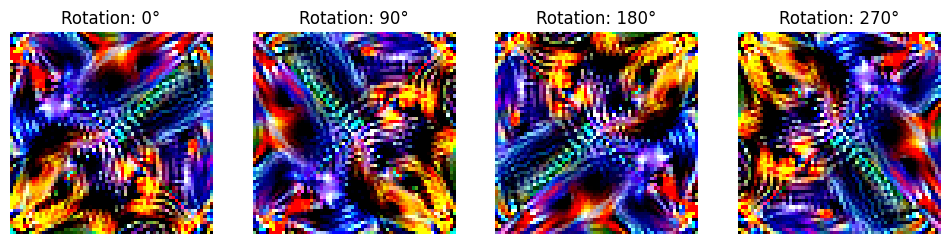

In [23]:
def visualize_patch(patch):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3))
    for i, angle in enumerate([0, 90, 180, 270]):
        rotated_patch = rotate_patch(patch, angle)
        rotated_patch = patch_forward(rotated_patch)  # Normalize patch for display

        # Convert tensor to numpy array for plotting
        patch_img = rotated_patch.permute(1, 2, 0).cpu().detach().numpy()
        patch_img = np.clip(patch_img, 0, 1)  # Ensure valid image range [0, 1]

        ax[i].imshow(patch_img)
        ax[i].axis('off')
        ax[i].set_title(f'Rotation: {angle}°')

    plt.show()

# Example usage
visualize_patch(patch_dict_1[name_1][64]['patch'])
# visualize_patch(patch_dict_2[name_2][64]['patch'])


In [64]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None, target=None):

    if isinstance(img, torch.Tensor):
        # Detach tensor and convert to numpy
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.detach().cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.detach().cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title(f'Predictions: Target - {target}')

    plt.show()
    plt.close()


Results for 0° rotated patch:


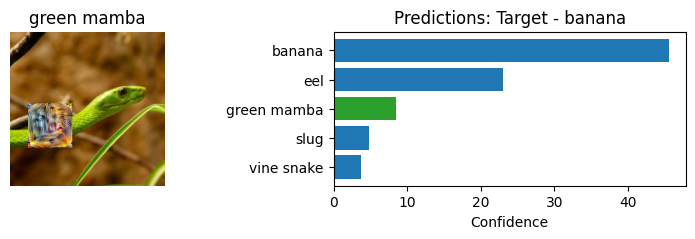

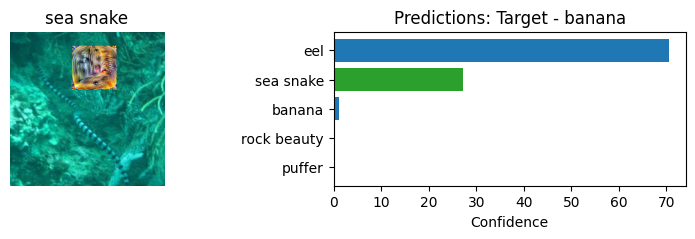

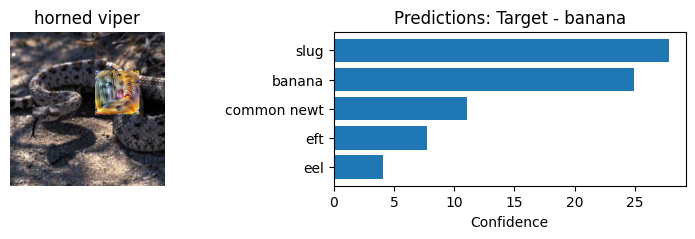

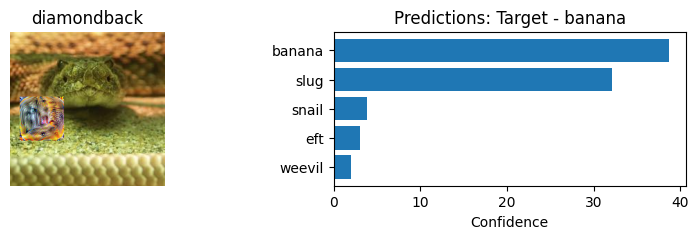

Results for 90° rotated patch:


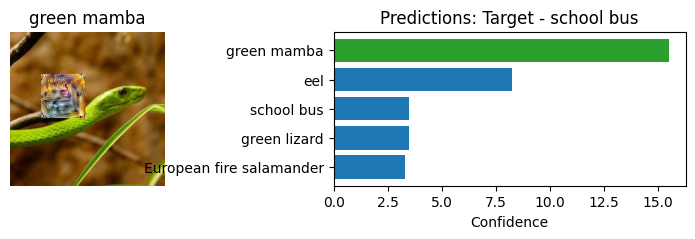

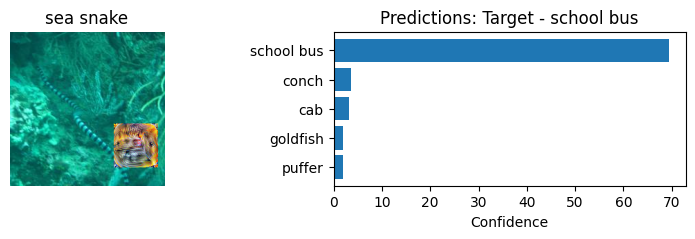

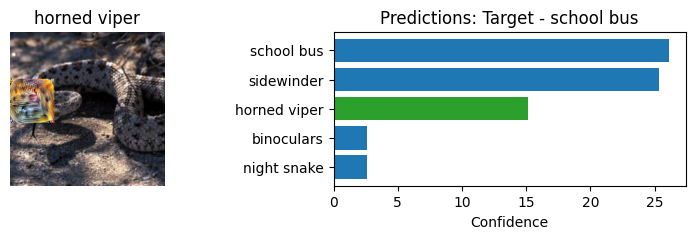

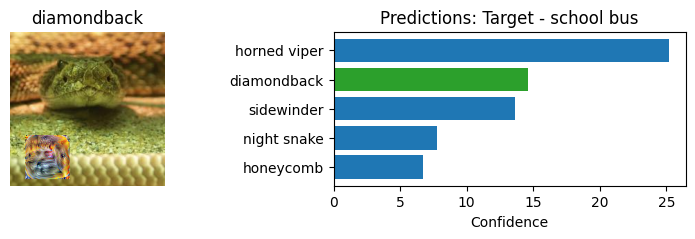

Results for 180° rotated patch:


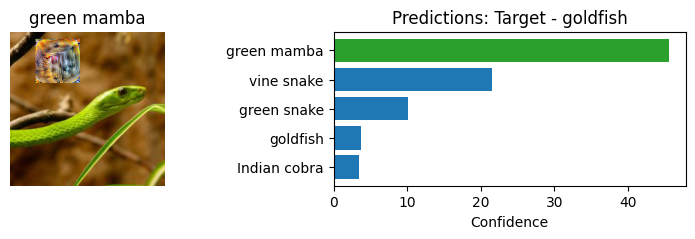

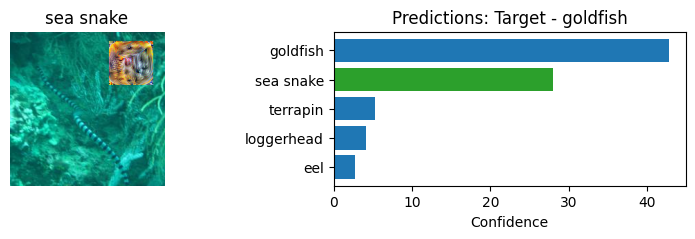

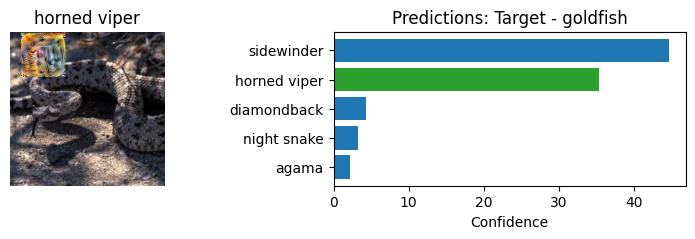

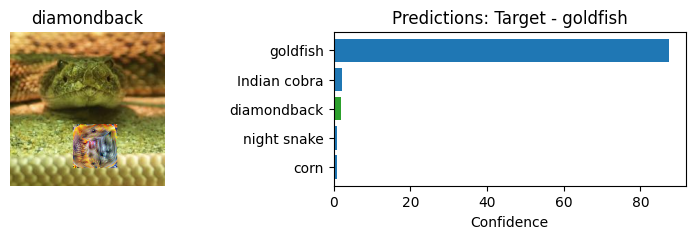

Results for 270° rotated patch:


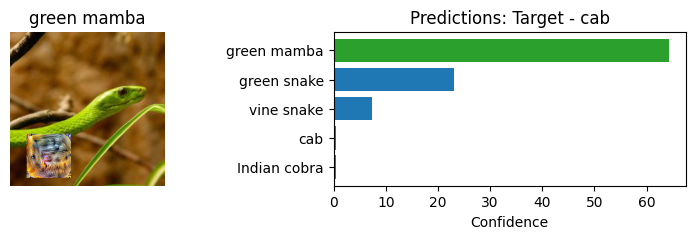

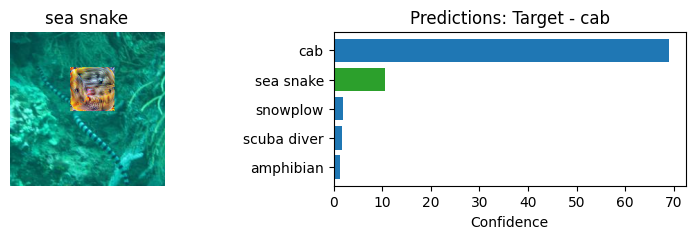

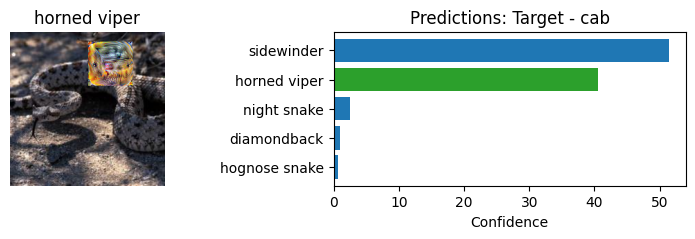

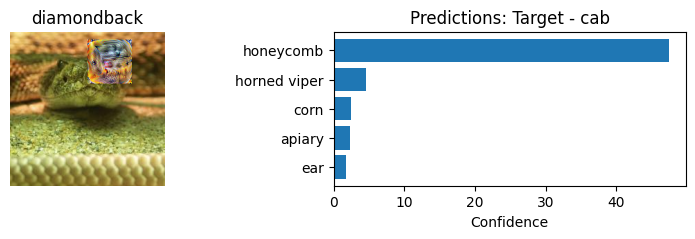

In [67]:
def get_nth_batch(data_loader, n):
    for idx, (data_batch, label_batch) in enumerate(data_loader):
        if idx == n:
            return data_batch, label_batch
    raise IndexError(f"Batch {n} is out of range")

# Get the 10th batch
exmp_batch, label_batch = get_nth_batch(data_loader, 10)  # Batch indices start at 0

def perform_patch_attack(patch, classes, angles=[0, 90, 180, 270]):
    for angle, target in zip(angles, classes):
        # Clone the original batch for each rotation
        patch_batch = exmp_batch.clone()
        
        # Rotate and place the patch
        rotated_patch = rotate_patch(patch, angle)
        patch_batch = place_patch(patch_batch, rotated_patch)
        
        # Get predictions
        with torch.no_grad():
            patch_preds = pretrained_model(patch_batch.to(device))
        
        print(f"Results for {angle}° rotated patch:")
        for i in range(1, 17, 5):
            show_prediction(patch_batch[i], label_batch[i], patch_preds[i], K=5, adv_img=None, noise=None, target=target)


perform_patch_attack(patch_dict_1[name_1][64]['patch'], classes_1)



Results for 0° rotated patch:


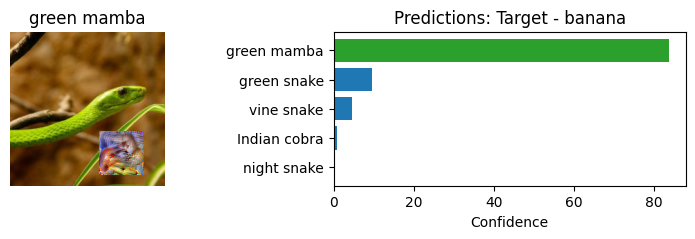

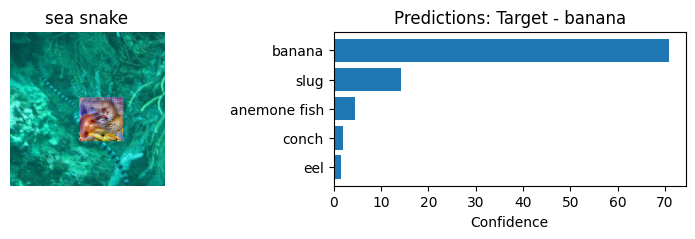

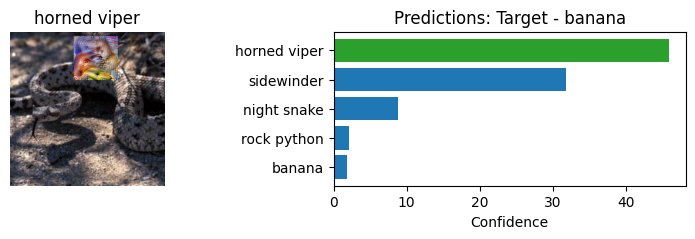

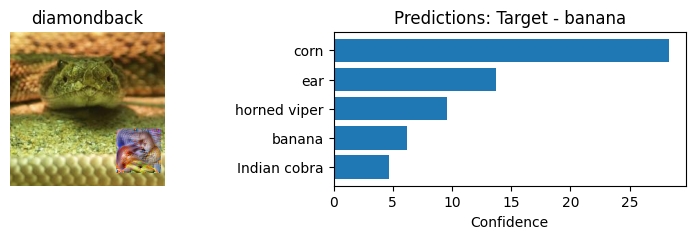

Results for 90° rotated patch:


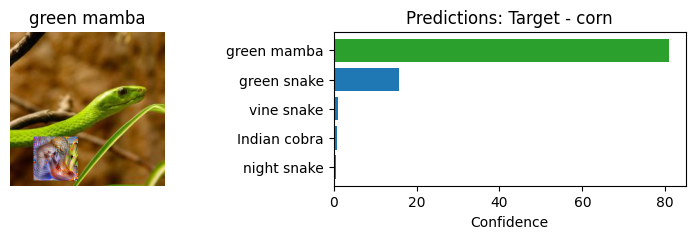

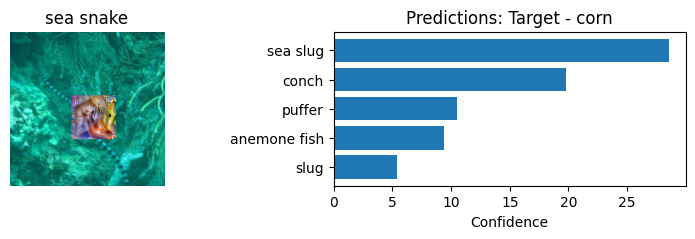

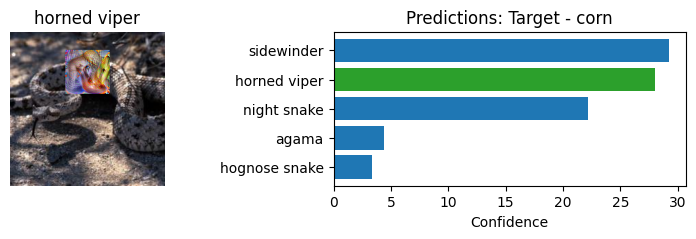

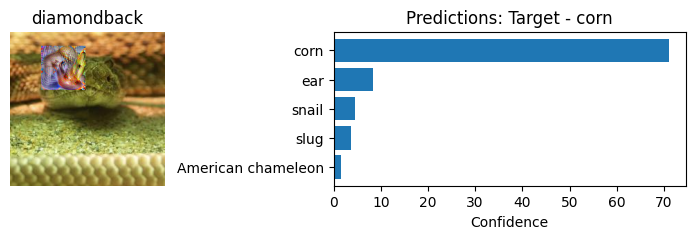

Results for 180° rotated patch:


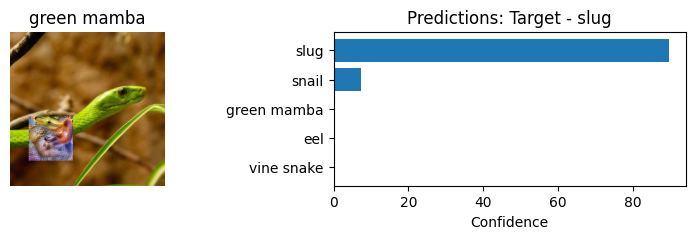

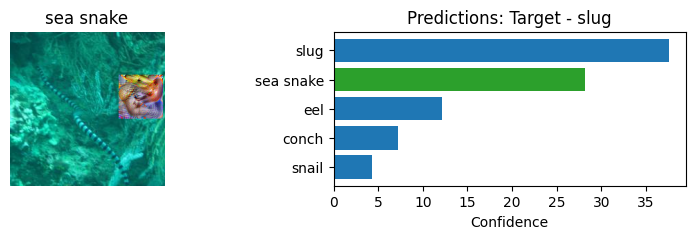

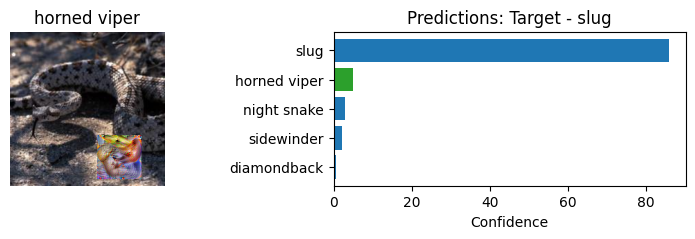

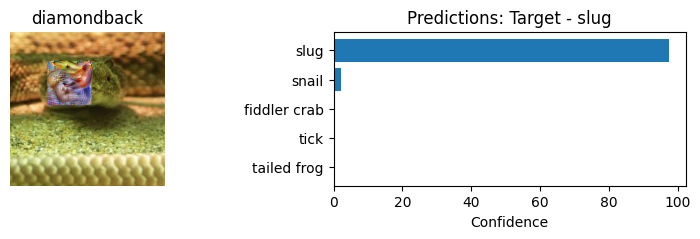

Results for 270° rotated patch:


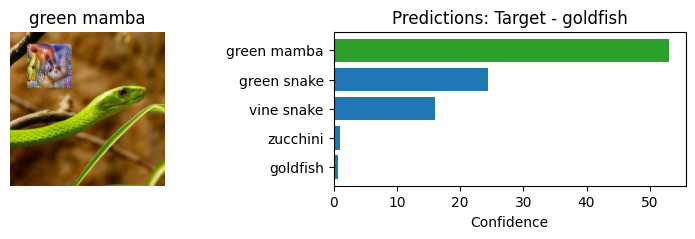

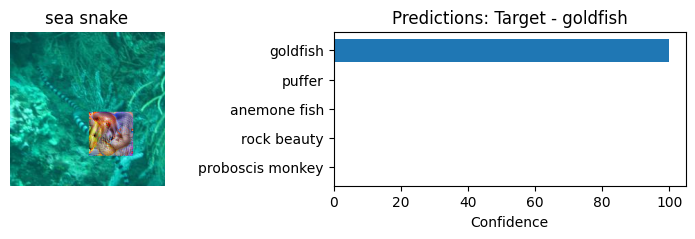

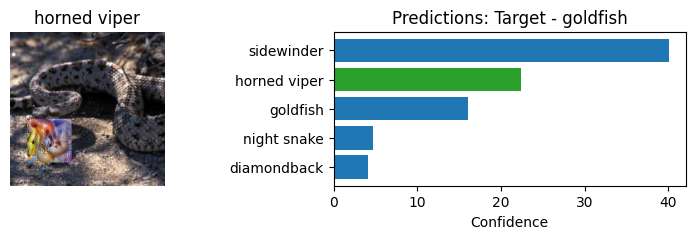

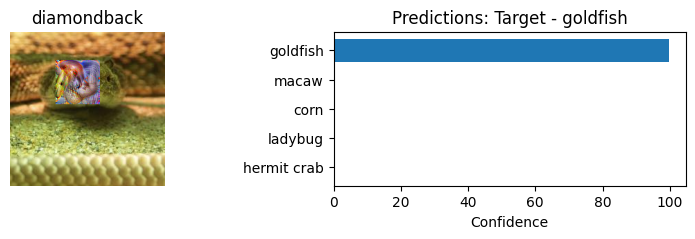

In [68]:
perform_patch_attack(patch_dict_2[name_2][64]['patch'], classes_2)